In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import json
import scienceplots
import wandb
import pickle
from matplotlib.colors import to_rgba

from copy import deepcopy

from src.problem import Instance
from src.utils import load_all_results

import os 
os.environ["PATH"] += os.pathsep + '/home/bruno/texlive/2023/bin/x86_64-linux/'

plt.style.use(['science','vibrant'])
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

instances_dir = Path('../data/raw/')
results_dir = Path('../data/results/')
opts_dir = Path('../data/interim')

# scheduling example

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


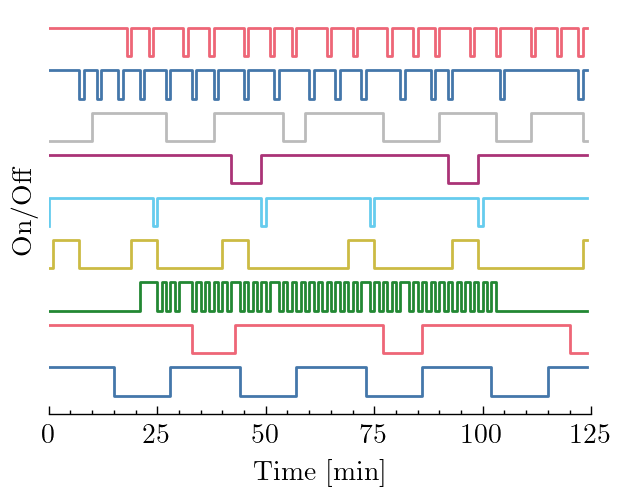

In [3]:
instance_fpath = next(instances_dir.glob('125_9_*.json'))
instance = Instance.from_file(instance_fpath)

opt_fp = opts_dir/(instance_fpath.name.replace('.json', '_opt.npz'))
obj, gap, runtime, X = np.load(opt_fp).values()

x = X[instance.vars_names.find('x(') >= 0]
x = x.reshape((instance.jobs, instance.T))

for i, j in enumerate(x):
    plt.step(np.arange(instance.T), j + i*1.5, label=i)

plt.xlim(0,instance.T)
plt.ylabel('On/Off')
plt.xlabel('Time [min]')

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks(np.linspace(0,125,6), )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.gcf().set_size_inches((6,6))

plt.tick_params(top=False, which='both')
plt.savefig('../schedule_example.pdf')
plt.show()

# feasibility classification

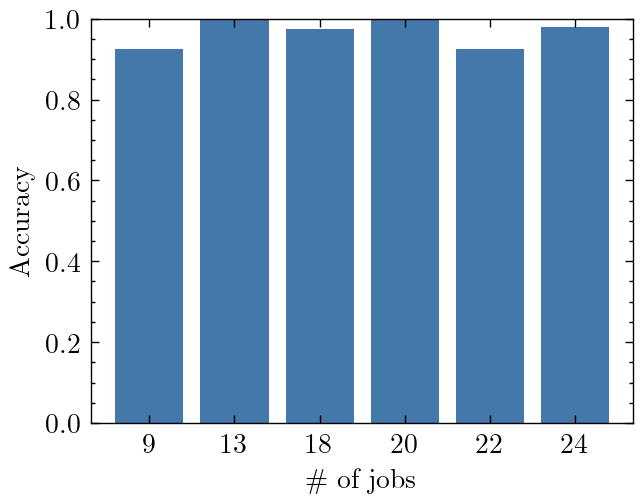

In [4]:
from collections import OrderedDict

accuracies = OrderedDict()
for size in [9,13,18,20,22,24]:
    runs = wandb.Api().runs(path='brunompac/sat-gnn', filters={'group': f'FeasClass-AcrossInstances-{size}'}, order='-created_at')
    run = runs[0]

    accuracies[size] = run.summary['val_loss_accuracy']

plt.bar(np.arange(len(accuracies.values())), accuracies.values(), tick_label=list(accuracies.keys()))

plt.xlabel('\# of jobs')
plt.ylabel('Accuracy')

plt.ylim(0,1)
# plt.minorticks_off()
plt.gcf().gca().set_xticks(list(), minor=True)
plt.savefig('../accuracy_classification_across_instances.pdf')
plt.show()

# optimality prediction

Optimals
0.28874673982384386


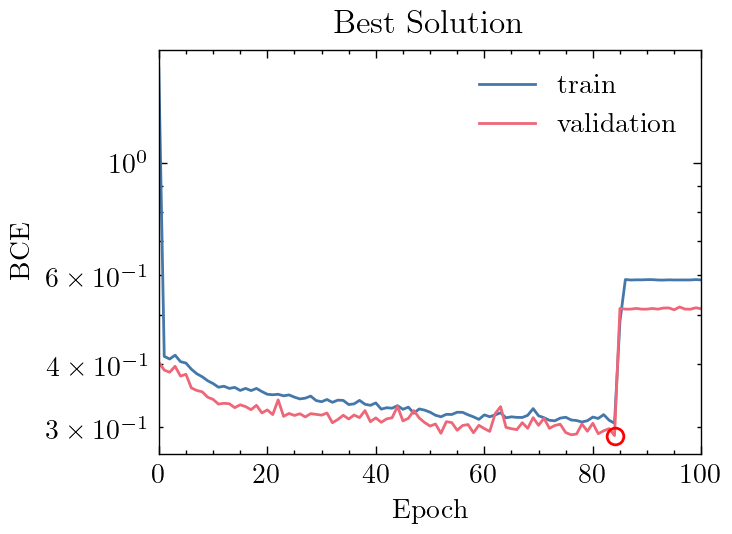

In [50]:
net_id = 'gbmooeqh'

api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
training_type = run.group[len('Best-'):]

df = run.history()
train_loss = df.train_loss.values
val_loss = df.val_loss.values

best_val_loss = run.summary['best_val']

fig, ax = plt.subplots()

ax.plot(train_loss, label='train')
ax.plot(val_loss, label='validation')
ax.plot(np.where(val_loss == best_val_loss)[0], [best_val_loss], 'o', color='r', fillstyle='none')

print(training_type)
print(best_val_loss)

plt.title('Best Solution')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')
plt.xlim(0,100)
plt.savefig('../training_curve_optimal.pdf')
plt.show()

MultiTarget
0.2451411026189783


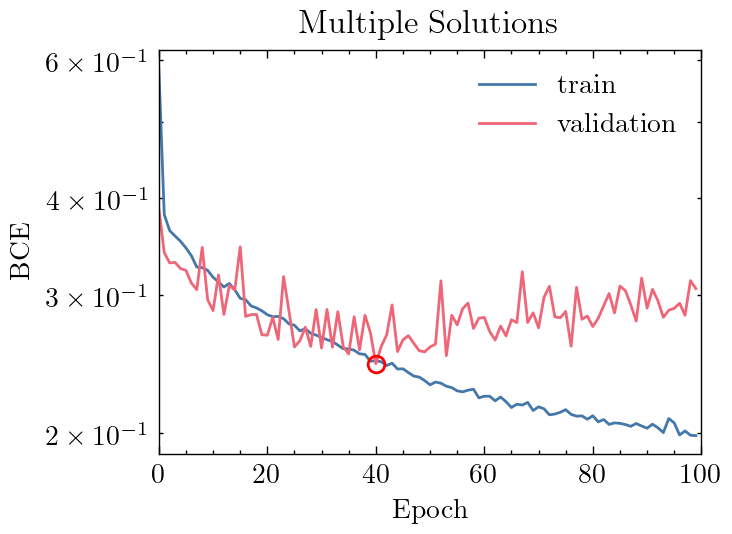

In [51]:
net_id = 'xae9giql'

api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
training_type = run.group[len('Best-'):]

df = run.history()
train_loss = df.train_loss.values
val_loss = df.val_loss.values

best_val_loss = run.summary['best_val']

fig, ax = plt.subplots()

ax.plot(train_loss * 500, label='train')
ax.plot(val_loss * 500, label='validation')
ax.plot(np.where(val_loss == best_val_loss)[0], [best_val_loss*500], 'o', color='r', fillstyle='none')

print(training_type)
print(best_val_loss * 500)

plt.title('Multiple Solutions')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')
plt.xlim(0,100)
plt.savefig('../training_curve_multi.pdf')
plt.show()

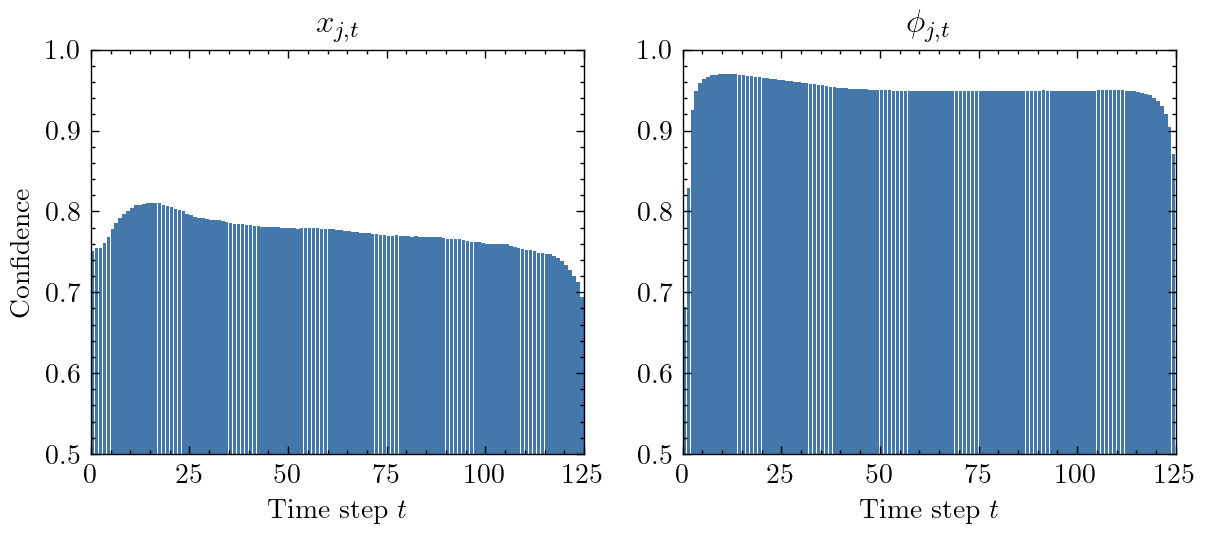

In [72]:
def var_conf_plot(conf, plot_title, filename=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.bar(np.arange(125), conf.mean(0), align='edge', width=.9)
    ax.set_xlim(0,125)
    ax.set_ylim(0.5,1)
    # plt.title('$x_{j,t}$ variables')
    ax.set_title(plot_title)
    # ax.set_ylabel('Confidence')
    ax.set_xlabel('Time step $t$')

    # if filename is not None:
    #     plt.savefig(filename, dpi=500)

    # plt.show()

with open('../gbmooeqh_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

var_conf_plot(X_conf, '$x_{j,t}$', ax=axs[0])
var_conf_plot(Phi_conf, '$\phi_{j,t}$', ax=axs[1])

axs[0].set_ylabel('Confidence')

fig.savefig('../optimals_confidence.pdf', dpi=500)
fig.show()

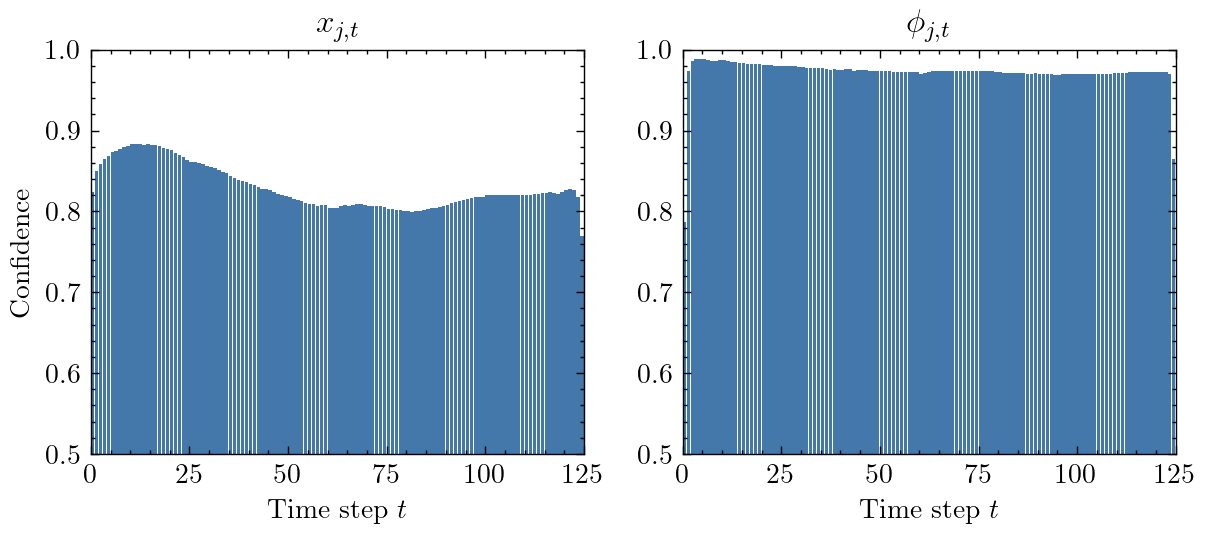

In [73]:
with open('../xae9giql_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

var_conf_plot(X_conf, '$x_{j,t}$', ax=axs[0])
var_conf_plot(Phi_conf, '$\phi_{j,t}$', ax=axs[1])

axs[0].set_ylabel('Confidence')

fig.savefig('../multiple_confidence.pdf', dpi=500)
fig.show()

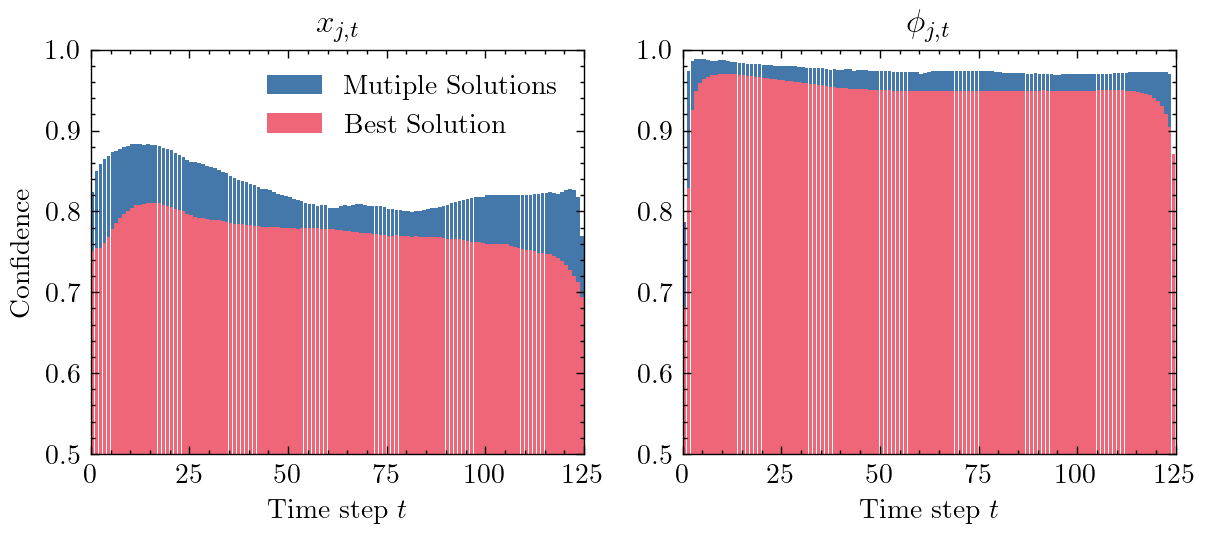

In [71]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

with open('../xae9giql_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

axs[0].bar(np.arange(125), X_conf.mean(0), align='edge', width=.9, label='Mutiple Solutions')
axs[1].bar(np.arange(125), Phi_conf.mean(0), align='edge', width=.9, label='Mutiple Solutions')

with open('../gbmooeqh_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

axs[0].bar(np.arange(125), X_conf.mean(0), align='edge', width=.9, label='Best Solution')
axs[1].bar(np.arange(125), Phi_conf.mean(0), align='edge', width=.9, label='Best Solution')

axs[0].set_xlim(0,125)
axs[0].set_ylim(0.5,1)
axs[0].set_title('$x_{j,t}$')
axs[0].set_xlabel('Time step $t$')

axs[1].set_xlim(0,125)
axs[1].set_ylim(0.5,1)
axs[1].set_title('$\phi_{j,t}$')
axs[1].set_xlabel('Time step $t$')

axs[0].set_ylabel('Confidence')

axs[0].legend()
fig.savefig('../confidences.pdf', dpi=500)
fig.show()

# test results

In [6]:
T = 125
TIME_BUDGET = 120

net_ids = {
    'Baseline': 'baseline',
    'Optimals': 'gbmooeqh',
    'MultiTarget': 'xae9giql',
}

hps = {
    'Baseline':{
        'obj': {
            'bs': 'bs_0',
        },
        'feas': {
            'bs': 'bs_0',
        }
    },
    'Optimals':{
        'obj': {
            'ws': 'ws_750',
            'ef': 'ef_500',
            'tr': 'tr_1000_5',
        },
        'feas': {
            'ws': 'ws_1000',
            'ef': 'ef_750',
            'tr': 'tr_1000_1',
        }
    },
    'MultiTarget':{
        'obj': {
            'ws': 'ws_1750',
            'ef': 'ef_1000',
            'tr': 'tr_1250_1',
        },
        'feas': {
            'ws': 'ws_1500',
            'ef': 'ef_1250',
            'tr': 'tr_1750_1',
        }
    }
}

In [10]:
dfs = list()
for m in hps.keys():
    for p in hps[m].keys():
        for h, sn in hps[m][p].items():
            fpaths = [fp for fp in results_dir.glob(f'{net_ids[m]}_{sn}_{T}_*.json') if int(fp.name.split('_')[-1][:-len('.json')]) >= 20]
            if len(fpaths) > 0:
                df = load_all_results(f"{net_ids[m]}_{hps[m][p][h]}", results_dir, opts_dir, test=True)
                df['model'] = m
                df['goal'] = p
                df['heuristic'] = h
                df['sn'] = hps[m][p][h]
                dfs.append(df)
df = pd.concat(dfs)
df['rel_obj'] = df['objective'] / df['opt_obj']

In [11]:
from src.utils import boxplot_bound

fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 2.625)

axs = boxplot_bound(df, 'obj', 'rel_obj', axs)

fig.show()

Error in callback <function _draw_all_if_interactive at 0x7f9e711c43a0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1200x525 with 2 Axes>

# heuristics

In [273]:
T = 125
TIME_BUDGET = 120

number_of_fixed_variables = [500, 750, 1000, 1250, 1500, 1750, 2000]
trustregion_deltas = [0.001, 0.01]

In [318]:
net_id = 'gbmooeqh'

api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
model_name = run.group[len('Best-'):]

df = load_all_results(f"baseline_bs_0", results_dir, opts_dir)
df['heuristic'] = 'Baseline'
df['n'] = 0
df['label'] = 'Baseline'
df['delta'] = 0
for n in number_of_fixed_variables:
    ws_df = load_all_results(f"{net_id}_ws_{n}", results_dir, opts_dir)
    if ws_df is not None:
        ws_df['heuristic'] = 'Warm-start'
        ws_df['n'] = n
        ws_df['label'] = f'Warm-start (n={n})'
        ws_df['delta'] = 0

        df = pd.concat([df, ws_df])

    ef_df = load_all_results(f"{net_id}_ef_{n}", results_dir, opts_dir)
    if ef_df is not None:
        ef_df['heuristic'] = 'Early-fix'
        ef_df['n'] = n
        ef_df['label'] = f'Early-fix (n={n})'
        ef_df['delta'] = 0

        df = pd.concat([df, ef_df])

    for delta in trustregion_deltas:
        tr_df = load_all_results(f"{net_id}_tr_{n}_{delta}", results_dir, opts_dir)
        if tr_df is not None:
            tr_df['heuristic'] = 'Trust region'
            tr_df['n'] = n
            tr_df['label'] = f'Trust region (n={n},$\Delta$={delta})'
            tr_df['delta'] = delta
            df = pd.concat([df, tr_df])

# warmstart_results = {f'Warm-start (n={n})': load_all_results(f"{net_id}_ws_{n}", results_dir, opts_dir)
#                      for n in number_of_fixed_variables}
# earlyfixing_results = {f'Early-fix (n={n})': load_all_results(f"{net_id}_ef_{n}", results_dir, opts_dir)
#                        for n in number_of_fixed_variables}
# trustregion_results = {f'Trust region (n={n})': load_all_results(f"{net_id}_tr_{n}_{delta}", results_dir, opts_dir)
#                        for n in number_of_fixed_variables for delta in trustregion_deltas}
                    
# results = {'Baseline': baseline_results}
# results.update(warmstart_results)
# results.update(earlyfixing_results)
# results.update(trustregion_results)

# for label, df in results.items():
#     if df is not None:
#         df['label'] = label

# df = pd.concat([r for r in results.values() if r is not None])

df['relative_objective'] = (df['objective'] / df['opt_obj']).astype(float)
# df['heuristic'] = df['label'].apply(lambda l: l.split('(')[0].rstrip())

# df['n'] = df['label'].apply(lambda l: l.split('=')[-1].rstrip(')'))
# df.loc[df['n'] == 'Baseline','n'] = 0
# df['n'] = df['n'].astype(int)
df = df.sort_values(by=['heuristic', 'delta', 'n'])

df.head()

,size,size_id,opt_obj,infeasible,runtime,objective,gap,primal_curve,time_to_feasible,heuristic,n,label,delta,relative_objective
0,20,6,12192,False,120.001260,12164.0,0.029356,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",102.598,Baseline,0,Baseline,0.0,0.997703
1,22,12,11356,False,120.003065,10799.0,0.250453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",86.297,Baseline,0,Baseline,0.0,0.950951
2,22,0,19498,False,120.004530,18017.0,0.126177,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.345,Baseline,0,Baseline,0.0,0.924043
3,20,3,11875,True,120.001690,0.0,-1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",120.000,Baseline,0,Baseline,0.0,0.000000
4,24,1,16373,False,120.000757,14152.0,0.380283,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",90.778,Baseline,0,Baseline,0.0,0.864350


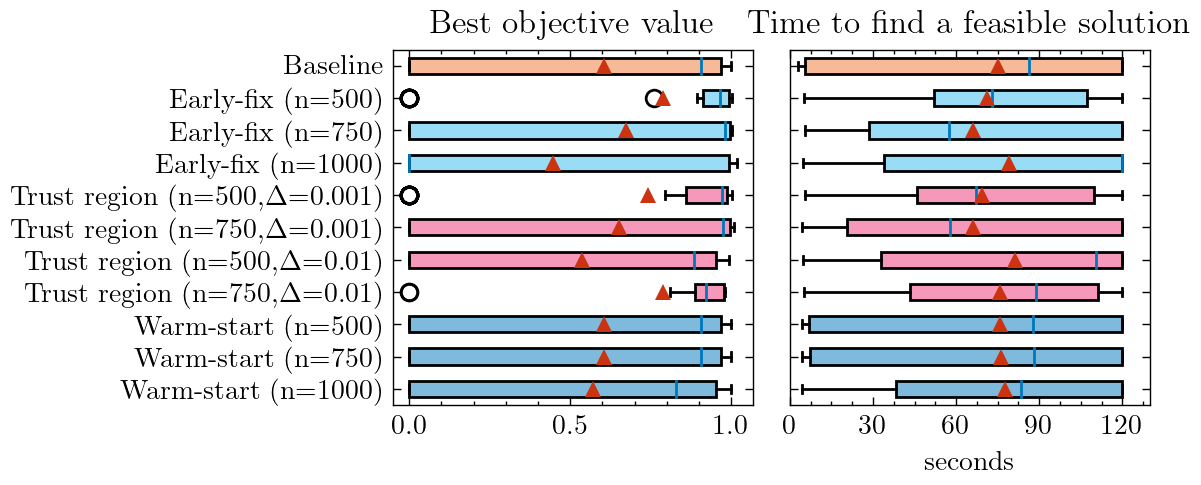

In [319]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(6, 2.625)

# labels = df.sort_values(by=['heuristic', 'n'])['label'].unique()[::-1]

def make_boxplot(col, ax):
    values = {l: df[df['label'] == l][col].values
              for l in df['label'].unique()[::-1]}

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    bar_colors = np.array([colors[0],] * len(values.keys()))
    bar_colors[[('Warm-start' in l) for l in values.keys()]] = colors[1]
    bar_colors[[('Early-fix' in l) for l in values.keys()]] = colors[2]
    bar_colors[[('Trust region' in l) for l in values.keys()]] = colors[3]

    bplot = ax.boxplot(values.values(), labels=values.keys(), showmeans=True,
                       vert=False, patch_artist=True, meanprops={'markerfacecolor': colors[4],
                                                                 'markeredgewidth': 0})

    for patch, color in zip(bplot['boxes'], bar_colors):
        c = to_rgba(color)
        c = (*c[:3], 0.5)
        patch.set_facecolor(c)

    ax.tick_params(axis='y', which='minor', length=0)

make_boxplot('relative_objective', axs[0])
axs[0].set_title('Best objective value')

make_boxplot('time_to_feasible', axs[1])

axs[1].set_xlim(0,130)
axs[1].set_xticks([0,30,60,90,120])
axs[1].set_yticklabels([])
axs[1].set_xlabel('seconds')
axs[1].set_title('Time to find a feasible solution')

fig.tight_layout()
fig.show()

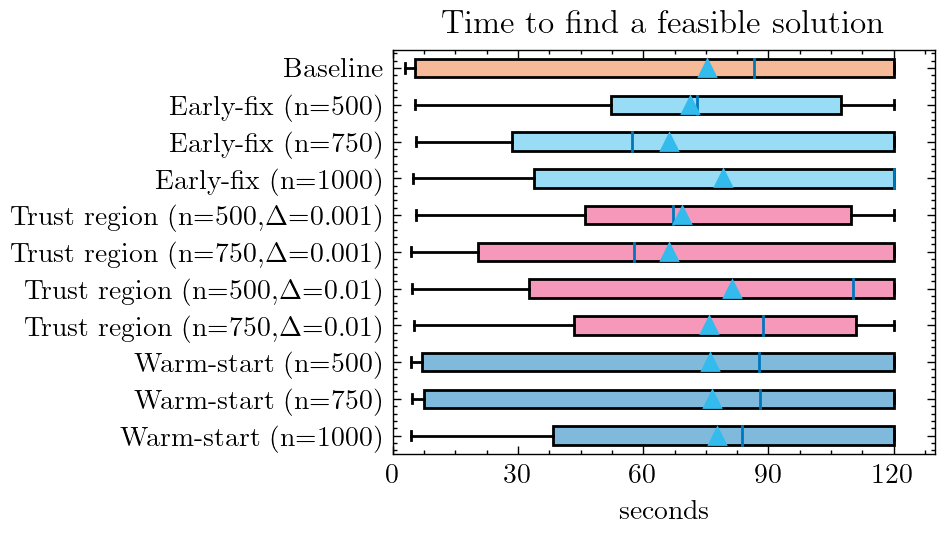

In [321]:
labels = df['label'].unique()[::-1]


times = {l: df[df['label'] == l]['time_to_feasible'].values
        for l in df['label'].unique()[::-1]}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
bar_colors = np.array([colors[0],] * len(times.keys()))
bar_colors[[('Warm-start' in l) for l in times.keys()]] = colors[1]
bar_colors[[('Early-fix' in l) for l in times.keys()]] = colors[2]
bar_colors[[('Trust region' in l) for l in times.keys()]] = colors[3]

bplot = plt.boxplot(times.values(), labels=times.keys(), showmeans=True,
                    vert=False, patch_artist=True)

for patch, color in zip(bplot['boxes'], bar_colors):
    c = to_rgba(color)
    c = (*c[:3], 0.5)
    patch.set_facecolor(c)

plt.title('Time to find a feasible solution')
plt.xlim(0,130)
plt.xticks([0,30,60,90,120])
plt.xlabel('seconds')
plt.show()

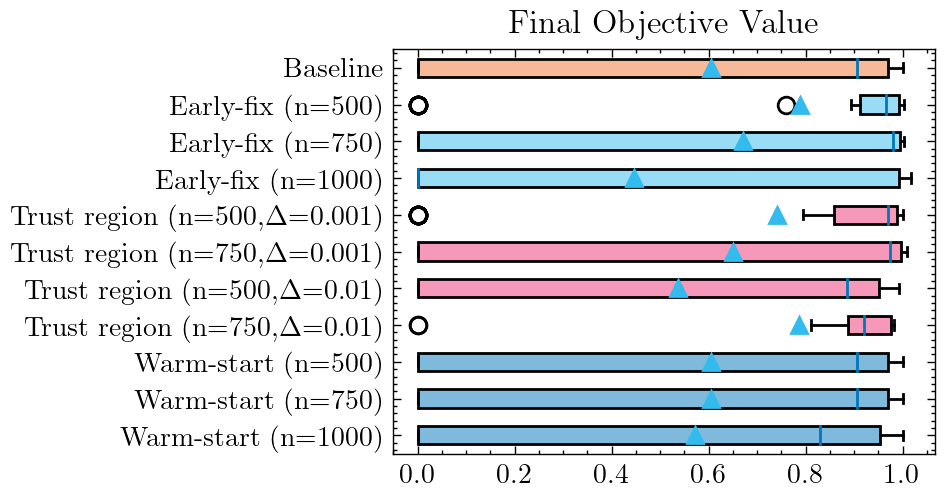

In [322]:
labels = df['label'].unique()[::-1]


objs = {l: df[df['label'] == l]['relative_objective'].values
        for l in df['label'].unique()[::-1]}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
bar_colors = np.array([colors[0],] * len(objs.keys()))
bar_colors[[('Warm-start' in l) for l in objs.keys()]] = colors[1]
bar_colors[[('Early-fix' in l) for l in objs.keys()]] = colors[2]
bar_colors[[('Trust region' in l) for l in objs.keys()]] = colors[3]

bplot = plt.boxplot(objs.values(), labels=objs.keys(), showmeans=True,
                    vert=False, patch_artist=True)

for patch, color in zip(bplot['boxes'], bar_colors):
    c = to_rgba(color)
    c = (*c[:3], 0.5)
    patch.set_facecolor(c)

# plt.title('Best Solution')
# plt.xlim(0,1.2)
plt.title('Final Objective Value')
# plt.yticks([])
plt.show()

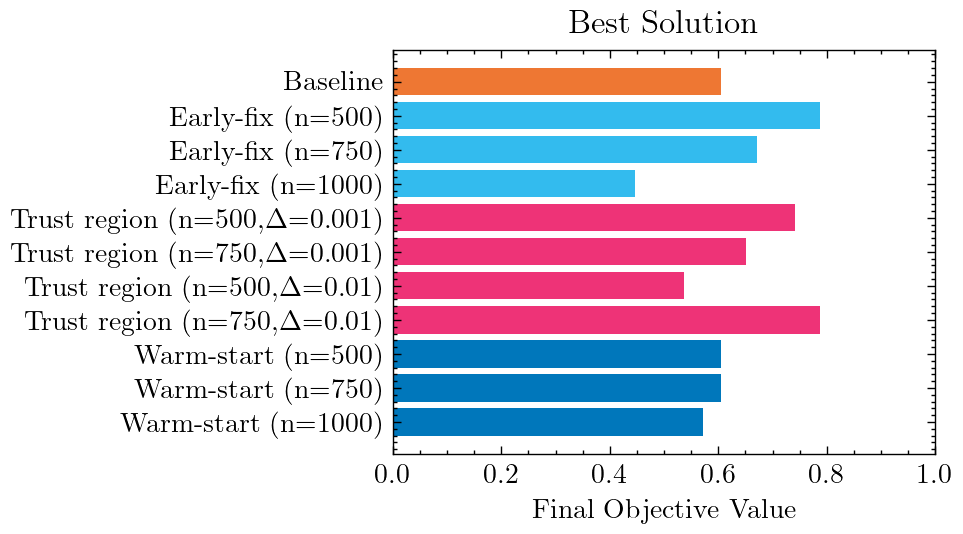

In [323]:
labels = df['label'].unique()[::-1]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
bar_colors = np.array([colors[0],] * len(labels))
bar_colors[[('Warm-start' in l) for l in labels]] = colors[1]
bar_colors[[('Early-fix' in l) for l in labels]] = colors[2]
bar_colors[[('Trust region' in l) for l in labels]] = colors[3]

means = df.groupby('label')['relative_objective'].mean().loc[labels]
# stds = df.groupby('label')['relative_objective'].std().loc[labels]

# plt.barh(np.arange(len(labels)), means, tick_label=labels, xerr=stds)
plt.barh(np.arange(len(labels)), means, tick_label=labels, color=bar_colors)

plt.title('Best Solution')
plt.xlim(0,1)
plt.xlabel('Final Objective Value')
plt.show()

In [325]:
means

,heuristic,delta,n,relative_objective
0,Early-fix,0.000,500,0.787375
1,Early-fix,0.000,750,0.671615
2,Early-fix,0.000,1000,0.446378
3,Trust region,0.001,500,0.741944
4,Trust region,0.001,750,0.651096
5,Trust region,0.010,500,0.537223
6,Trust region,0.010,750,0.787263
7,Warm-start,0.000,500,0.604615
8,Warm-start,0.000,750,0.604553
9,Warm-start,0.000,1000,0.571651


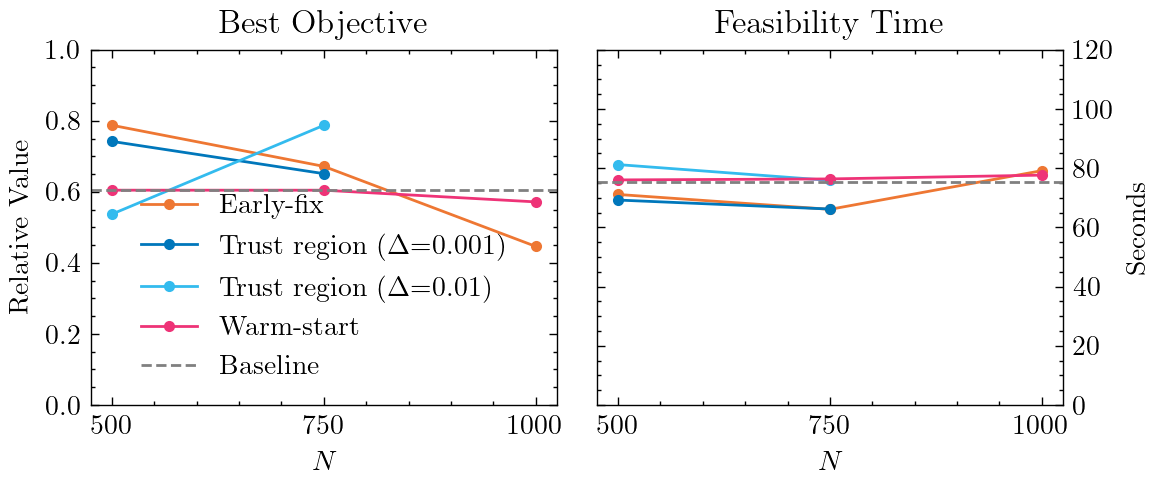

In [343]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 2.625)

def make_lineplot(column, ax):
    means = df[df['heuristic'] != 'Baseline'].groupby(['heuristic', 'delta', 'n'])[column].mean().reset_index()
    # stds = df[df['heuristic'] != 'Baseline'].groupby(['heuristic', 'n'])['relative_objective'].std().reset_index()
    for h in means['heuristic'].unique():
        if h == 'Trust region':
            for delta in means[means['heuristic'] == h]['delta'].unique():
                h_means = means[(means['heuristic'] == h) & (means['delta'] == delta)].set_index('n')[column]

                ax.plot(h_means, marker='.', label=h+f' ($\Delta$={delta})')
        else:
            h_means = means[means['heuristic'] == h].set_index('n')[column]
            # h_stds = stds[stds['heuristic'] == h].set_index('n')['relative_objective']
            # plt.errorbar(h_means.index, h_means.values, yerr=h_stds.values, marker='.', label=h)
            ax.plot(h_means, marker='.', label=h)

    baseline_obj = df[df['heuristic'] == 'Baseline'][column].mean()

    ax.set_xticks(means['n'].unique())

    xlim = ax.get_xlim()
    ax.hlines(baseline_obj, *xlim, label='Baseline', linestyles='dashed', color='gray')
    ax.set_xlim(*xlim)

make_lineplot('relative_objective', axs[0])

axs[0].set_ylim(0,1)
axs[0].legend()
axs[0].set_title('Best Objective')
axs[0].set_ylabel('Relative Value')
axs[0].set_xlabel('$N$')

make_lineplot('time_to_feasible', axs[1])

axs[1].set_ylim(0,120)
# axs[1].legend()
axs[1].set_ylabel('Seconds')
axs[1].set_xlabel('$N$')
axs[1].set_title('Feasibility Time')
axs[1].yaxis.tick_right()
axs[1].yaxis.set_ticks_position('both')
axs[1].yaxis.set_label_position("right")

fig.tight_layout()
fig.show()